<a href="https://colab.research.google.com/github/nrajmalwar/EVA-6-Phase-1/blob/main/Session_05/Model_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Target
1. Add dropout value of 0.1 to all the layers except the last one
2. Add BatchNormalization to all the layer except the last one

# Result
1. Parameters - 9,436 (slight increase due to BatchNormalization)
2. Best Train Acc - 99.20% (Increase)
3. Best Test Acc - 99.42% (Increase)

# Analysis 
1. Regularization and BatchNormalization has resulted in stabilization of train accuracy and increase in test accuracy.
2. Model is slightly underfitting, which means there is scope to increase the accuracy further.
3. Test accuracy iof 99.42% is achieved only in the last epoch.
4. Next we apply data augmentation to train the model harder and achieve 99.42% test accuracy earlier. Analysing the misclassified shows us that some images require rotation for the model to understand the visual differences between some numbers like (7,1), (2,1) and (4,9).
5. We will also apply slight distortion to train model to rectify images which are harder to read otherwise. Distortion can help improve readibility of images that are difficult even for the human eye.

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
!pip install torchsummary
from torchsummary import summary

# Data Transformations


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Data Statistics

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
torch.Size([128])


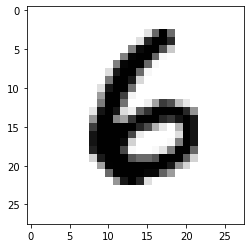

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.data.cpu().numpy().shape)
print(' - Tensor Shape:', train.data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

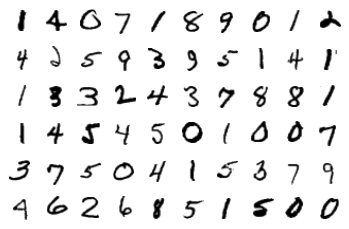

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The Model - Add dropout and BatchNormalization

In [7]:
# Adding Dropout
dropout_value = 0.1

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # INPUT BLOCK
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 26, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
        ) # output_size = 24, RF = 5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) 
          # output_size = 12, RF = 6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 12, RF = 6


        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 10, RF = 10

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 8, RF = 14

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6, RF = 18

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 4, RF = 22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1, RF = 28

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # No activation in last layer
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params


In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
              ReLU-2           [-1, 12, 26, 26]               0
       BatchNorm2d-3           [-1, 12, 26, 26]              24
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 14, 24, 24]           1,512
              ReLU-6           [-1, 14, 24, 24]               0
       BatchNorm2d-7           [-1, 14, 24, 24]              28
         MaxPool2d-8           [-1, 14, 12, 12]               0
            Conv2d-9           [-1, 10, 12, 12]             140
           Conv2d-10           [-1, 14, 10, 10]           1,260
             ReLU-11           [-1, 14, 10, 10]               0
      BatchNorm2d-12           [-1, 14, 10, 10]              28
          Dropout-13           [-1, 14, 10, 10]               0
           Conv2d-14             [

# Training and Testing Functions

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Model Training and Testing

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.03850657865405083 Batch_id=468 Accuracy=90.24: 100%|██████████| 469/469 [00:10<00:00, 46.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0585, Accuracy: 9842/10000 (98.42%)

EPOCH: 1


Loss=0.1010030210018158 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:10<00:00, 46.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0376, Accuracy: 9884/10000 (98.84%)

EPOCH: 2


Loss=0.04456247389316559 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:10<00:00, 46.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9904/10000 (99.04%)

EPOCH: 3


Loss=0.02035178430378437 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:10<00:00, 45.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9928/10000 (99.28%)

EPOCH: 4


Loss=0.047523949295282364 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:10<00:00, 45.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9913/10000 (99.13%)

EPOCH: 5


Loss=0.010178345255553722 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:10<00:00, 45.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9923/10000 (99.23%)

EPOCH: 6


Loss=0.016786115244030952 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:10<00:00, 45.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9933/10000 (99.33%)

EPOCH: 7


Loss=0.013980798423290253 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:10<00:00, 45.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9924/10000 (99.24%)

EPOCH: 8


Loss=0.022883379831910133 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:10<00:00, 45.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9932/10000 (99.32%)

EPOCH: 9


Loss=0.04519123211503029 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:10<00:00, 45.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9937/10000 (99.37%)

EPOCH: 10


Loss=0.005861333105713129 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:10<00:00, 44.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9938/10000 (99.38%)

EPOCH: 11


Loss=0.0073670316487550735 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:10<00:00, 45.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9938/10000 (99.38%)

EPOCH: 12


Loss=0.03086025081574917 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:10<00:00, 44.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9914/10000 (99.14%)

EPOCH: 13


Loss=0.035151902586221695 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:10<00:00, 44.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9921/10000 (99.21%)

EPOCH: 14


Loss=0.023948168382048607 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:10<00:00, 45.03it/s]



Test set: Average loss: 0.0185, Accuracy: 9942/10000 (99.42%)



# Accuracy and Loss Graphs

Text(0.5, 1.0, 'Test Accuracy')

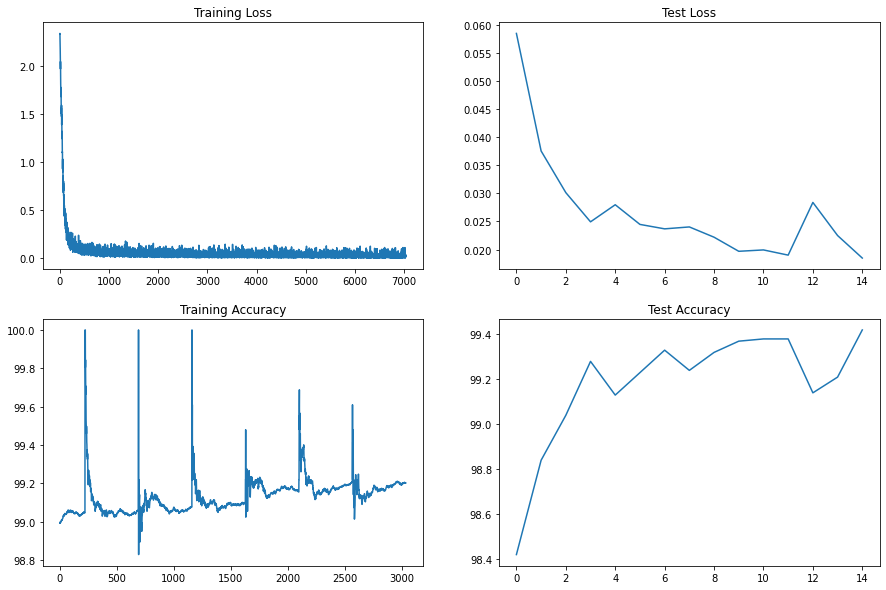

In [11]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Misclassified Images

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


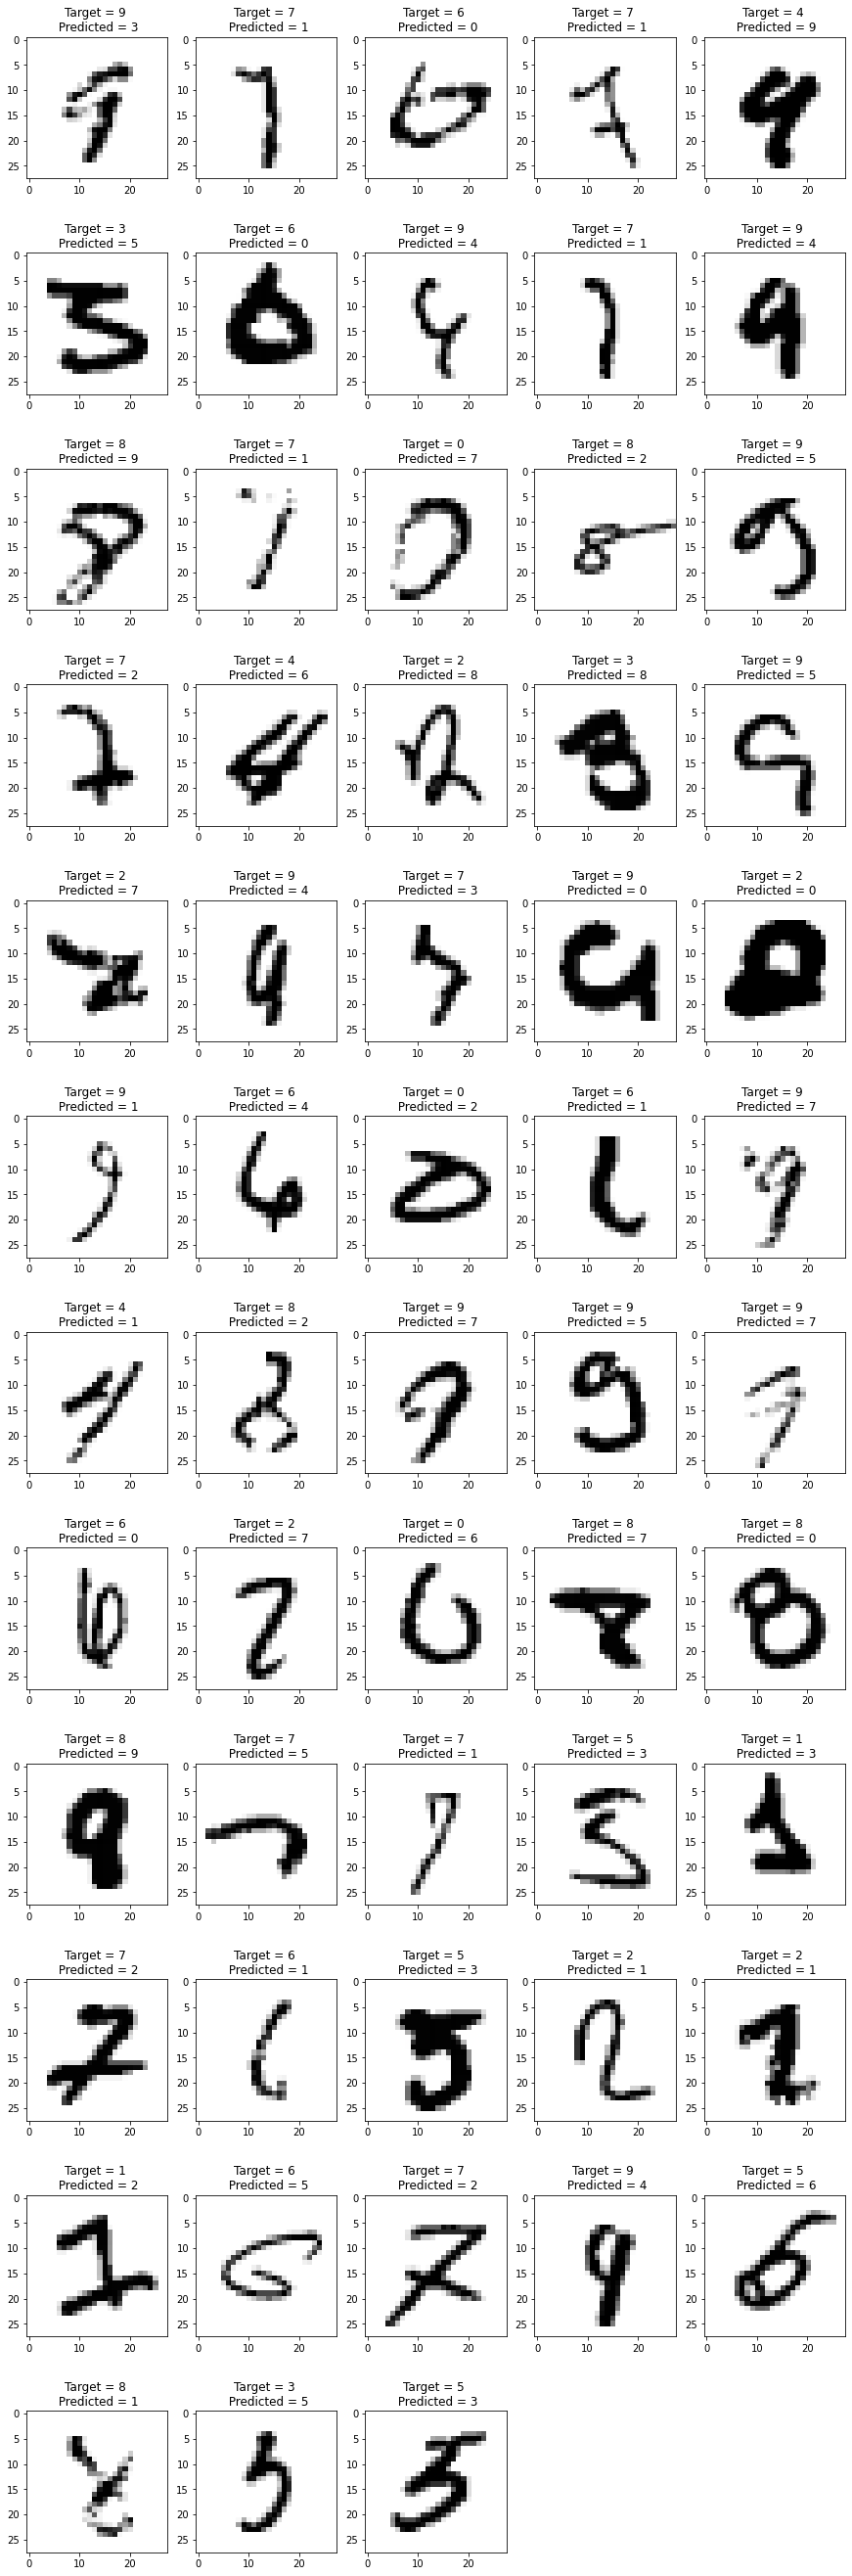

In [12]:
model.eval()

# Create a test loader with batch size equal to test data length
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=len(test), num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=len(test))
# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        # Get the indexes of images that are incorrectly classified
        indexes = (pred.view(-1,) != target.view(-1,)).nonzero()

        # Plot the misclassified images
        rows = np.ceil(len(indexes)/5)
        fig = plt.figure(figsize=(15, rows*4))
        for i, idx in enumerate(indexes):
            ax = fig.add_subplot(rows, 5, i+1)
            ax.imshow(data[idx].cpu().numpy().squeeze(), cmap='gray_r')
            ax.set_title(f"Target = {target[idx].item()} \n Predicted = {pred[idx].item()}")
        
        plt.show()